RECOLECCION Y FILTRADO DE DATOS: 

OBTENEMOS LOS DATOS EN FORMATO CSV, ADEMAS DEL INDICE DE VARIABLES SELECCIONADAS EN ARCHIVO HTML.
LA PAGINA ES: ESS DATA PORTAL, ORGANISMO EUROPEO DE ENCUESTAS POR PAISES.
RECOLECTAN DATOS SOCIODEMOGRAFICOS , POLÍTICOS, BIENESTAR SOCIAL , ETC.

NOS CENTRAREMOS EN LOS DATOS RECOLECTADOS EN DOS GRUPOS DELIMITADOS POR EL GRADO DE INFLACION(DEFLACION DEL PIB) DE LA ZONA EURO.
LA FUENTE DE DATOS PARA LA CLASIFICACION POR PIB PER CAPITA E INFLACION LA OBTENEMOS DE LA WEB OFICIAL DEL BANCO MUNDIAL.
''https://datos.bancomundial.org/indicator/NY.GDP.DEFL.KD.ZG?end=2023&locations=EU&most_recent_value_desc=true&start=1960&view=chart''

EN EL GRUPO 1 ESTARAN LOS TRES PAISES CON MAYOR INFLACION(RANGO COMPRENDIDO ENTRE 14,7-11,7) DE LA EUROZONA Y DE LOS CUALES SE TIENEN DATOS SOCIOECONOMICOS ACTUALIZADOS: HUNGRIA, SLOVAKIA Y CROACIA.
EN EL GRUPO 2 ESTARAN LOS TRES PAISES CON MENOR INFLACION DE LA EUROZONA: FINLANDIA, BÉLGICA E IRLANDA.

EN EL CRITERIO DE SELECCION DE PAISES PARA LOS GRUPOS HEMOS TENIDO EN CUENTA OTROS FACTORES IMPORTANTES:
Los paises de los grupos han de tener datos oficiales socioeconomicos actualizados (en el grupo 1 hemos omitido Rumania por este motivo), una cercania geografica relativamente alta, las caracteristicas como país además han de ser parecidas(país sin ventajas fiscales, en el grupo 2 hemos omitido por este motivo Luxemburgo y Chipre, trato politico ecuanime en la eurozona, cultura similar.)
Dentro del estudio hemos obviado dinamarca, dado que es el unico pais de la zona euro con una inflacion negativa, por lo que el grado de satisfaccion  y mentalidad ciudadana va a estar influenciado y se va a reflejar en los datos obtenidos de las encuestas.

https://ess.sikt.no/en/
Hacemos una seleccion de variables dentro de las posibilidades que nos ofrece el selector de la web:
Escogemos los apartados de mass media, políticas, bienestar social, y valores humanos.
Haremos una seleccion de datos y las tablas se almacenaran en SQL para utilizarlas en otro notebook de exploracion de datos
y realizar asi el feature engineering.


In [1]:
#PRIMERO DE TODO VAMOS A HACER UN CLUSTER DE PAISES BASANDONOS EN CRITERIOS ECONOMICOS BASICOS.
#1) Creacion de Subgrupos de paises:
import pandas as pd
from sqlalchemy import create_engine, text
import os
import sqlite3
#1.1 Nos conectamos a la base de datos.
database_path = os.path.abspath("C:/GitHubRepos/ProyectoFinal/data/processed/Dataset9k.db")
print(f"Database path: {database_path}")
conn = create_engine(f'sqlite:///{database_path}')
# Execute the SQL query, ya hemos visto en el visualizador de sql que los datos que deberian ser numericos hay algunas columnas que son formato texto, 
# hacemos un query para transformarlos justo antes de almacenarlos en un dataframe

#DF inflacion
query = """
SELECT País, REPLACE(Inflación, ',', '.') AS Inflación_Float
FROM EuroInfl
"""
#Creamos un diccionario para almacenar la conversion
dtype_dict = {'Inflación_Float': float}
# Load the DataFrame with the dtype dictionary
df_inf = pd.read_sql_query(query, conn, dtype=dtype_dict)
df_inf.drop_duplicates(subset='País', keep='first', inplace=True)

#DF PPC
query = f"""
SELECT País, ROUND(PPC) AS PPC_INTEGER
FROM EuroPPC
"""
df_PPC = pd.read_sql_query(query, conn)
df_PPC.drop_duplicates(subset='País', keep='first', inplace=True)
print(df_PPC)

#DF SBMM
query = """
SELECT País, REPLACE(SBMM, ',', '.') AS SBMM_Float
FROM EuroSBMM
"""
dtype_dict = {'SBMM': float}
df_SBMM = pd.read_sql_query(query, conn)
df_SBMM.drop_duplicates(subset='País', keep='first', inplace=True)
df_SBMM['País'] = df_SBMM['País'].str.strip().str.lower()

conn.dispose()
print(df_SBMM)


Database path: C:\GitHubRepos\ProyectoFinal\data\processed\Dataset9k.db
                  País  PPC_INTEGER
0        Unión Europea         41.0
1             Bulgaria         16.0
2              Rumania         18.0
3              Croacia         22.0
4              Polonia         22.0
5              Hungría         22.0
6              Letonia         23.0
7               Grecia         23.0
8   República Eslovaca         24.0
9             Portugal         27.0
10            Lituania         28.0
11             Estonia         30.0
12     República Checa         32.0
13           Eslovenia         33.0
14              España         34.0
15              Chipre         37.0
16              Italia         39.0
17               Malta         40.0
18             Francia         45.0
19           Finlandia         53.0
20            Alemania         54.0
21             Bélgica         55.0
22              Suecia         56.0
23             Austria         56.0
24        Países Bajos      

In [2]:
#No hay forma de cambiar la columna paises de la tabla SBMM, por lo que habra que realizar un diccionario de equivalencias para hacer coincidir la columna paises en los tres
#Dataframes de graficos, realizaremos posteriormente una clusterizacion para elegir 3 subgrupos de paises con economias similares y poder compararlos
#A nivel general con la Union Europea.
país_equivalencias = {
    'bulgaria :bg:': 'Bulgaria',
    'rumanía :ro:': 'Rumania',
    'hungría :hu:': 'Hungría',
    'croacia :hr:': 'Croacia',
    'polonia :pl:': 'Polonia',
    'letonia :lv:': 'Letonia',
    'eslovaquia :sk:': 'República Eslovaca',
    'grecia :gr:': 'Grecia',
    'lituania :lt:': 'Lituania',
    'estonia :ee:': 'Estonia',
    'portugal :pt:': 'Portugal',
    'república checa :cz:': 'República Checa',
    'malta :mt:': 'Malta',
    'chipre :cy:': 'Chipre',
    'eslovenia :si:': 'Eslovenia',
    'españa :es:': 'España',
    'italia :it:': 'Italia',
    'media ue :eu:': 'Unión Europea',
    'francia :fr:': 'Francia',
    'suecia :se:': 'Suecia',
    'finlandia :fi:': 'Finlandia',
    'austria :at:': 'Austria',
    'países bajos :nl:': 'Países Bajos',
    'bélgica :be:': 'Bélgica',
    'irlanda :ie:': 'Irlanda',
    'alemania :de:': 'Alemania',
    'dinamarca :dk:': 'Dinamarca',
    'luxemburgo :lu:': 'Luxemburgo',
}
df_SBMM['País'] = df_SBMM['País'].map(país_equivalencias)
print(df_SBMM)

                  País SBMM_Float
0           Luxemburgo       3713
1            Dinamarca       3573
2             Alemania       3148
3              Irlanda       3051
4              Bélgica       3007
5              Austria       2964
6         Países Bajos       2964
7            Finlandia       2678
8               Suecia       2604
9              Francia       2574
10       Unión Europea       2194
11              Italia       2174
12              España       1822
13           Eslovenia       1503
14              Chipre       1359
15               Malta       1354
16     República Checa       1208
17            Portugal       1154
18             Estonia       1123
19            Lituania       1110
20              Grecia       1049
21  República Eslovaca       1046
22             Letonia        978
23             Polonia        941
24             Croacia        903
25             Hungría        852
26             Rumania        796
27            Bulgaria        650


In [3]:
#Antes de la concatenacion de los dataframe hemos de hacer coincidir el tipo de datos, coincidir el index 

df_inf.reset_index(drop=True, inplace=True)
print(df_inf['País'].dtype)
print(df_inf['Inflación_Float'].dtype)
print(df_inf)

object
float64
                  País  Inflación_Float
0            Dinamarca             -3.8
1        Unión Europea              6.4
2           Luxemburgo              3.4
3              Irlanda              3.6
4               Chipre              3.8
5            Finlandia              3.9
6              Bélgica              4.5
7              Francia              5.3
8                Malta              5.3
9               Italia              5.8
10              Grecia              5.9
11            Alemania              6.1
12              Suecia              6.1
13              España              6.2
14             Letonia              6.4
15             Austria              6.6
16            Portugal              6.9
17        Países Bajos              7.3
18            Bulgaria              8.0
19             Estonia              8.1
20     República Checa              8.2
21            Lituania              9.0
22             Polonia              9.5
23           Eslovenia   

In [4]:
#df_PPC dtypes
df_PPC.reset_index(drop=True, inplace=True)
print(df_PPC['País'].dtype)
print(df_PPC['PPC_INTEGER'].dtype)

object
float64


In [5]:
#df_SBMM
df_SBMM.reset_index(drop=True, inplace=True)
print(df_SBMM['País'].dtype)
print(df_SBMM['SBMM_Float'].dtype)
#Aqui tenemos el problema, hemos de pasar la columna SBMM_FLoat a float64
df_SBMM['SBMM_Float'] = df_SBMM['SBMM_Float'].astype('float64')
print(df_SBMM['SBMM_Float'].dtype)

object
object
float64


In [6]:
#Preparamos el dataframe concatenado filtrando por valores unicos de paises y sus valores numericos en cada uno de los dataframes.
# Encontrar países comunes
paises_comunes = set(df_inf['País']).intersection(set(df_PPC['País']), set(df_SBMM['País']))

# Filtrar DataFrames para países comunes y establecer 'País' como índice
df_i1 = df_inf[df_inf['País'].isin(paises_comunes)].set_index('País')
df_P1 = df_PPC[df_PPC['País'].isin(paises_comunes)].set_index('País')
df_S1 = df_SBMM[df_SBMM['País'].isin(paises_comunes)].set_index('País')
# Concatenar los DataFrames por columnas
df_IPS = pd.concat([df_i1, df_P1, df_S1], axis=1)
#Eliminamos variables usadas que no son inutiles.
df_IPS.to_csv('C:/GitHubRepos/ProyectoFinal/data/processed/EuEco.csv', index=True)
del df_i1, df_P1, df_S1, df_inf, df_SBMM, df_PPC, país_equivalencias, dtype_dict, paises_comunes, df_IPS
df1= pd.read_csv('C:\GitHubRepos\ProyectoFinal\data\processed\EuEco.csv')
print(df1)

                  País  Inflación_Float  PPC_INTEGER  SBMM_Float
0            Dinamarca             -3.8         68.0      3573.0
1        Unión Europea              6.4         41.0      2194.0
2           Luxemburgo              3.4        129.0      3713.0
3              Irlanda              3.6        104.0      3051.0
4               Chipre              3.8         37.0      1359.0
5            Finlandia              3.9         53.0      2678.0
6              Bélgica              4.5         55.0      3007.0
7              Francia              5.3         45.0      2574.0
8                Malta              5.3         40.0      1354.0
9               Italia              5.8         39.0      2174.0
10              Grecia              5.9         23.0      1049.0
11            Alemania              6.1         54.0      3148.0
12              Suecia              6.1         56.0      2604.0
13              España              6.2         34.0      1822.0
14             Letonia   

<>:14: SyntaxWarning: invalid escape sequence '\G'
<>:14: SyntaxWarning: invalid escape sequence '\G'
C:\Users\Josue\AppData\Local\Temp\ipykernel_1136\1683118009.py:14: SyntaxWarning: invalid escape sequence '\G'
  df1= pd.read_csv('C:\GitHubRepos\ProyectoFinal\data\processed\EuEco.csv')


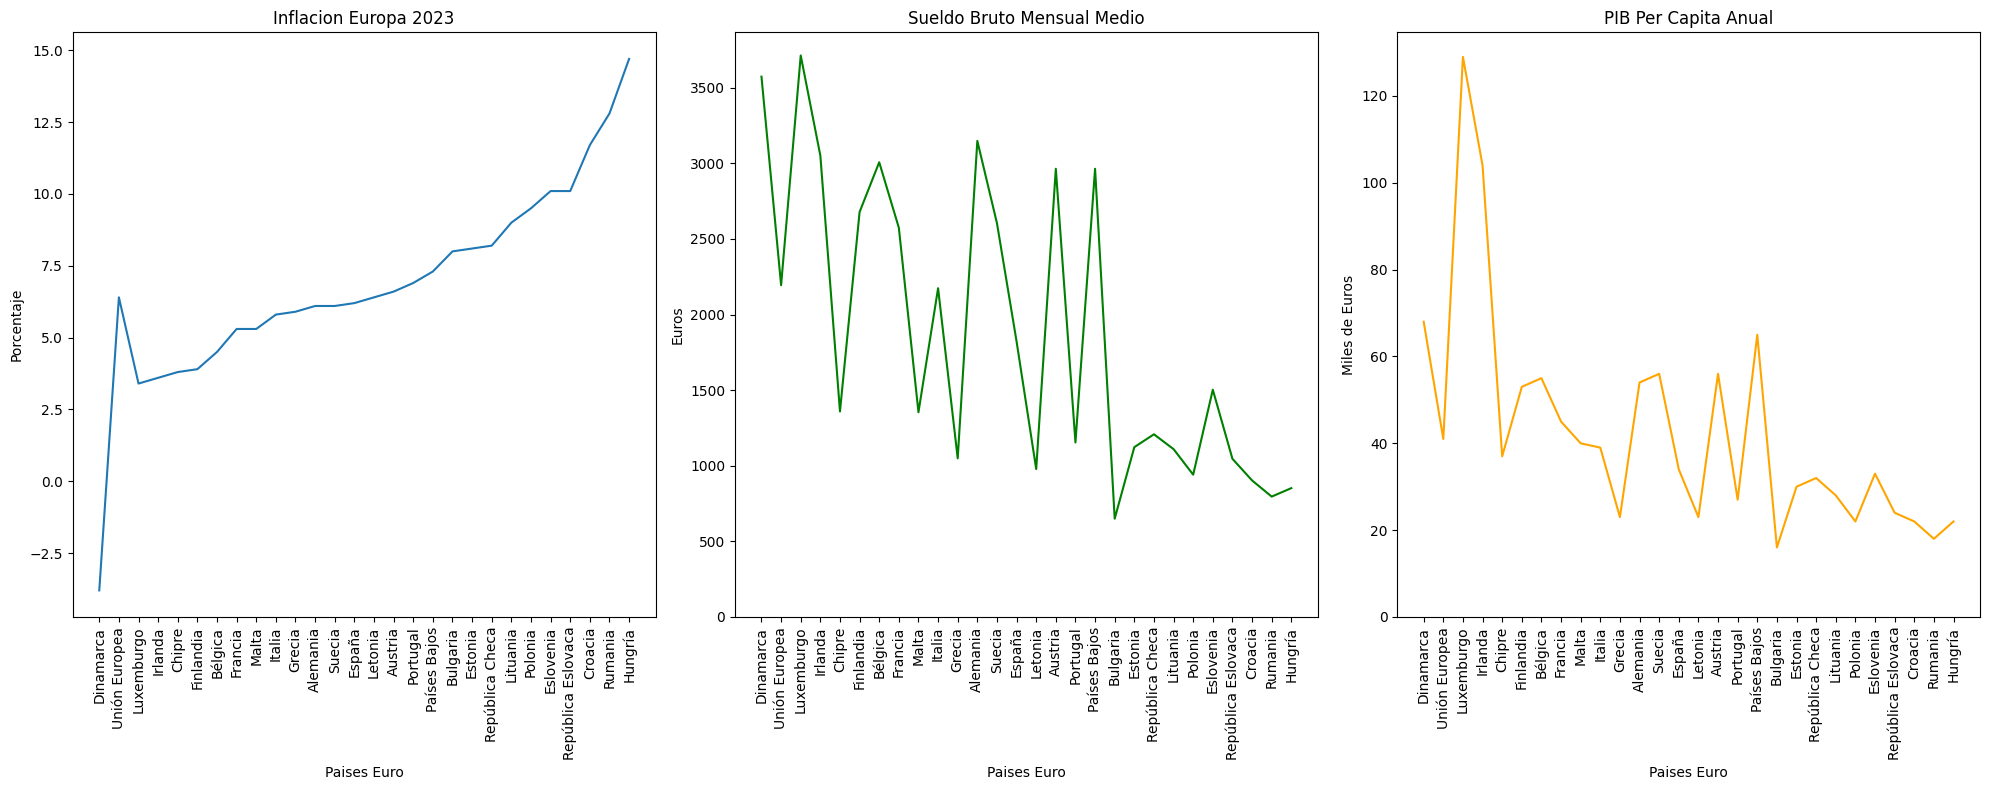

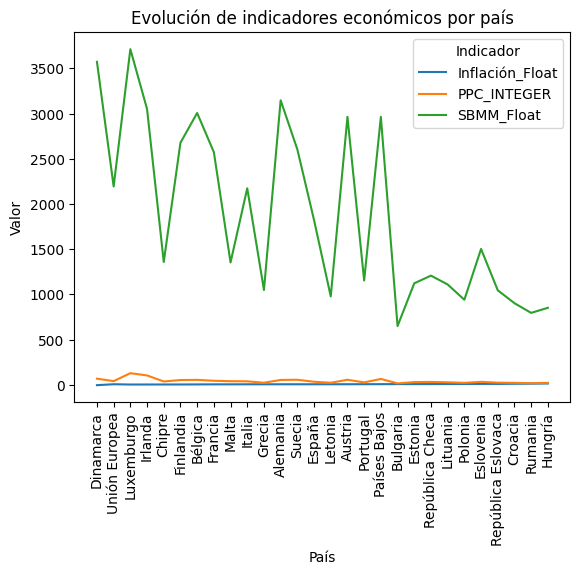

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#1.5 Representacion Graficos Economicos.
# Crear una grupo de graficos lineales con 3 subplots en una fila
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
# Graficar cada DataFrame en un subplot diferente
axes[0].plot(df1['País'], df1['Inflación_Float'])
axes[0].set_title('Inflacion Europa 2023')
axes[0].set_xlabel('Paises Euro')
axes[0].set_ylabel('Porcentaje')
axes[0].tick_params(axis='x', rotation=90)  

axes[1].plot(df1['País'], df1['SBMM_Float'], color='Green')
axes[1].set_title('Sueldo Bruto Mensual Medio')
axes[1].set_xlabel('Paises Euro')
axes[1].set_ylabel('Euros')
axes[1].set_ylim(ymin=0) 
axes[1].tick_params(axis='x', rotation=90)  

axes[2].plot(df1['País'], df1['PPC_INTEGER'],  color='Orange')
axes[2].set_title('PIB Per Capita Anual')
axes[2].set_xlabel('Paises Euro')
axes[2].set_ylabel('Miles de Euros')
axes[2].set_ylim(ymin=0)  
axes[2].tick_params(axis='x', rotation=90) 
plt.tight_layout()
plt.show()
df1.set_index('País', inplace=True)
for column in ['Inflación_Float', 'PPC_INTEGER', 'SBMM_Float']:
    sns.lineplot(data=df1, x=df1.index, y=column, label=column)
plt.title('Evolución de indicadores económicos por país')
plt.xlabel('País')
plt.ylabel('Valor')
plt.legend(title='Indicador')
plt.xticks(rotation=90)

plt.show()
del axes

In [8]:
#Ahora vamos a crear 3 subgrupos de paises: 
#Los haremos automaticamente con KMeans, podemos predecir los grupos
#por las caracteristicas economicas.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px

X = df1[['Inflación_Float', 'PPC_INTEGER', 'SBMM_Float']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df1['cluster'] = kmeans.labels_
fig = px.scatter_3d(df1, x='Inflación_Float', y='PPC_INTEGER', z='SBMM_Float',
              color='cluster',
              opacity=0.7,
              color_continuous_scale='viridis',
              symbol='cluster',
              size_max=18)
fig.update_layout(
    title='Clustering de países en 3D',
    scene = dict(
        xaxis_title='Inflación',
        yaxis_title='PPC',
        zaxis_title='SBMM'
    ),
    legend=dict(
        title='Cluster',
        yanchor="top",
        xanchor="right"
    )
)

fig.show()

In [9]:
#Ahora llamamos a los valores unicos del indice default del df1 que se agrupan en cada cluster para seleccionar ademas 
#del criterio matematico, razones geograficas y culturales.

for i in range(kmeans.n_clusters):
    cluster_i = df1[df1['cluster'] == i].index
    print(f"Países en el cluster {i}:")
    print(cluster_i.tolist())

Países en el cluster 0:
['Dinamarca', 'Luxemburgo', 'Irlanda', 'Finlandia', 'Bélgica', 'Francia', 'Alemania', 'Suecia', 'Austria', 'Países Bajos']
Países en el cluster 1:
['Chipre', 'Malta', 'Grecia', 'Letonia', 'Portugal', 'Bulgaria', 'Estonia', 'República Checa', 'Lituania', 'Polonia', 'Eslovenia', 'República Eslovaca', 'Croacia', 'Rumania', 'Hungría']
Países en el cluster 2:
['Unión Europea', 'Italia', 'España']


SELECCION DE VARIABLES DE LOS DATOS DE ESS PORTAL:
Como ya he comentado, para nuestro proyecto tomaremos en cuenta solo 4 grandes bloques de todos los datos recolectados en ESS, añadiremos un factor bayesiano y aleatorio en el bloque 5 para reducir la interpretabilidad de los datos.

Variables Bloque 1(Media), Media use and Trust (Uso, tipo de los medios de informacion, y grado de confianza).De todas las variables explicadas y recolectadas nos quedamos:

Variables Bloque 2(Politicas),  Políticas(perfil politico del individuo, participacion an nivel social y político, etc):

Variables Bloque 3(Bienestar),  Bienestar social(Situaci;on social del individuo, etnia, etc.):

Varibales Bloque 4(Valores e Inquietudes),  Valores Humanos(Objetivos de vida, inquietudes, enfoque de la vida, etc.):



TODAS LAS VARIABLES SON CATEGÓRICAS FACTORIZADAS Y ALGUNAS EN ESCALA ARBITRARIA DE 0 A 1 CON VALORES INTERMEDIOS.
SE DESCARTARAN VALORES DE VARIABLES INCONCLUSOS.(//value)


SELECCION VARIABLES BLOQUE 1 (Media):
VAR netusoft - Internet use, how often
Value	Category
1	Never
2	Only occasionally
3	A few times a week
4	Most days
5	Every day
//7	Refusal*-DISCARDED
//8	Don't know*-DISCARDED
//9	No answer*-DISCARDED

VAR nwsptot - Newspaper reading, total time on average weekday
Value	Category
0	No time at all
1	Less than 0,5 hour
2	0,5 hour to 1 hour
3	More than 1 hour, up to 1,5 hours
4	More than 1,5 hours, up to 2 hours
5	More than 2 hours, up to 2,5 hours
6	More than 2,5 hours, up to 3 hours
7	More than 3 hours
//77	Refusal*-DISCARDED
//88	Don't know*-DISCARDED
//99	No answer* -DISCARDED

VAR ppltrst - Most people of the media can be trusted or you can't be too careful (VAR TARGET DEL BLOQUE 1)
Value	Category
0	You can't be too careful
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Most people can be trusted
//77	Refusal* -DISCARDED
//88	Don't know* -DISCARDED
//99	No answer*-DISCARDED

VAR rdtot - Radio listening, total time on average weekday.

Value	Category
0	No time at all
1	Less than 0,5 hour
2	0,5 hour to 1 hour
3	More than 1 hour, up to 1,5 hours
4	More than 1,5 hours, up to 2 hours
5	More than 2 hours, up to 2,5 hours
6	More than 2,5 hours, up to 3 hours
7	More than 3 hours
//77	Refusal*-DISCARDED
//88	Don't know*-DISCARDED
//99	No answer*-DISCARDED

VAR tvtot - TV watching, total time on average weekday.
Value	Category
0	No time at all
1	Less than 0,5 hour
2	0,5 hour to 1 hour
3	More than 1 hour, up to 1,5 hours
4	More than 1,5 hours, up to 2 hours
5	More than 2 hours, up to 2,5 hours
6	More than 2,5 hours, up to 3 hours
7	More than 3 hours
//77	Refusal*-DISCARDED
//88	Don't know*-DISCARDED
//99	No answer*-DISCARDED

VAR pplfair - Most people try to take advantage of you, or try to be fair
ESCALA DE 0 A 10
//77	Refusal*-DISCARDED
//88	Don't know*-DISCARDED
//99	No answer*-DISCARDED

Resumen columnas/variables 5, BLOQUE 1: df_rd['netusoft','nwsptot','ppltrst','rdtot','tvtot','pplfair'], eliminaremos los valores 7,8,9 y 77,88,99

SELECCION VARIABLES BLOQUE 2 (Político):

Las siguientes columnas faltan en el DataFrame: {'dclaid B1', 'ccnthum', 'rdtot', 'nwsptot', 'dclagr', 'tvtot', 'dmcntov', 'dclwlfr', 'blgetmg', 'ginveco', 'dclenv', 'lawobey', 'dclcrm', 'dclmig', 'vteumbgb'}

VAR actrolga - Able to take active role in political group(Variable Target BLOQUE 2)
Value	Category
1	Not at all able
2	A little able
3	Quite able
4	Very able
5	Completely able
//7	Refusal*
//8	Don't know*
//9	No answer*

VAR bctprd - Boycotted certain products last 12 months
Value	Category
1	Yes
2	No
//7	Refusal*
//8	Don't know*
//9	No answer*

VAR dclagr - Preferred decision level of agricultural policies
Value	Category
1	International level
2	European level
3	National level
4	Regional or local level
//7	Refusal*
//8	Don't know*
//9	No answer*

VAR dclaid - Preferred decision level of policies about aid to developing countries
Value	Category
1	International level
2	European level
3	National level
4	Regional or local level
//7	Refusal*
//8	Don't know*
//9	No answer

VAR dclcrm - Preferred decision level of fighting against organised crime policies
Value	Category
1	International level
2	European level
3	National level
4	Regional or local level
//7	Refusal*
//8	Don't know*
//9	No answer*

VAR dclenv - Preferred decision level of environmental protection policies
Value	Category
1	International level
2	European level
3	National level
4	Regional or local level
//7	Refusal*
//8	Don't know*
//9	No answer*

VAR dclmig - Preferred decision level of immigration and refugees policies
Value	Category
1	International level
2	European level
3	National level
4	Regional or local level
//7	Refusal*
//8	Don't know*
//9	No answer*

VAR dclwlfr - Preferred decision level of social welfare policies
Value	Category
1	International level
2	European level
3	National level
4	Regional or local level
//7	Refusal*
//8	Don't know*
//9	No answer*

VAR dmcntov - How democratic [country] is overall(Target Var num 2 Bloque 2.)
Value	Category
0	Not at all democratic
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Completely democratic
//77	Refusal*
//88	Don't know*
//99	No answer*

VAR euftf - European Union: European unification go further or gone too far
Value	Category
0	Unification already gone too far
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Unification go further
//77	Refusal*
//88	Don't know*
//99	No answer*

VAR  gincdif - Government should reduce differences in income levels
Value	Category
1	Agree strongly
2	Agree
3	Neither agree nor disagree
4	Disagree
5	Disagree strongly
//77	Refusal*
//88	Don't know*
//99	No answer*

VAR  ginveco - The less government intervenes in economy, the better for country
Value	Category
1	Agree strongly
2	Agree
3	Neither agree nor disagree
4	Disagree
5	Disagree strongly
//77	Refusal*
//88	Don't know*
//99	No answer*

VAR lawobey - The law should always be obeyed
Value	Category
1	Agree strongly
2	Agree
3	Neither agree nor disagree
4	Disagree
5	Disagree strongly
//7	Refusal*
//8	Don't know*
//9	No answer*

VAR  lrscale - Placement on left right scale(Posible var target numero 3 del Bloque 2)
Value	Category
0	Left
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Right
//77	Refusal*
//88	Don't know*
//99	No answer*

VAR polintr - How interested in politics
Value	Category
1	Very interested
2	Quite interested
3	Hardly interested
4	Not at all interested
//7	Refusal*
//8	Don't know*
//9	No answer*

Var stfeco - How satisfied with present state of economy in country
Value	Category
0	Extremely dissatisfied
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Extremely satisfied
//77	Refusal*
//88	Don't know*
//99	No answer*

Var  stfedu - State of education in country nowadays
Value	Category
0	Extremely bad
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Extremely good
//77	Refusal*
//88	Don't know*
//99	No answer*

Var stfgov - How satisfied with the national government
Value	Category
0	Extremely dissatisfied
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Extremely satisfied
//77	Refusal*
//88	Don't know*
//99	No answer*

Var stfhlth - State of health services in country nowadays
0	Extremely bad
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Extremely good
//77	Refusal*
//88	Don't know*
//99	No answer*

Var stflife - How satisfied with life as a whole
Value	Category
0	Extremely dissatisfied
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Extremely satisfied
//77	Refusal*
//88	Don't know*
//99	No answer*

Var trstplc - Trust in the police
Value	Category
0	No trust at all
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Complete trust
//77	Refusal*
//88	Don't know*
//99	No answer*

Var trstplt - Trust in politicians
Value	Category
0	No trust at all
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Complete trust
//77	Refusal*
//88	Don't know*
//99	No answer*


Var trstun - Trust in the United Nations
Value	Category
0	No trust at all
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Complete trust
//77	Refusal*
//88	Don't know*
//99	No answer*

Var trstsci - Trust in scientists
Value	Category
0	No trust at all
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Complete trust
//77	Refusal*
//88	Don't know*
//99	No answer*

Var imbgeco - Immigration bad or good for country's economy
Value	Category
0	Bad for the economy
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Good for the economy
//77	Refusal*
//88	Don't know*
//99	No answer*
resumen columnas/variables 25, BLOQUE 2: df_rd['actrolga','bctprd','dclagr','dclaid','dclcrm','dclenv', 'dclmig', 'dclwlfr', 'dmcntov', 'euftf', 'gincdif', 'ginveco', 'lawobey', 'lrscale', 'polintr','stfeco','stfedu', 'stfgov', 'stfhlth', 'stflife', 'trstplc', 'trstplt', 'trstun', 'trstsci', 'imbgeco']

SELECCION VARIABLES BLOQUE 3(Bienestar),  Bienestar social(Situación social del individuo, etnia, etc.):


Var pplhlp - Most of the time people helpful or mostly looking out for themselves
Would you say that most of the time people try to be helpful or that they are mostly looking out for themselves?

Escala de 0 a 10.
//77	Refusal*
//88	Don't know*
//99	No answer*

Var aesfdrk - Feeling of safety of walking alone in local area after dark
Value	Category
1	Very safe
2	Safe
3	Unsafe
4	Very unsafe
//7	Refusal*
//8	Don't know*
//9	No answer*

Var atchctr - How emotionally attached to [country]
Value	Category
0	Not at all emotionally attached
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Very emotionally attached
//77	Refusal*
//88	Don't know*
//99	No answer*

Var atcherp - How emotionally attached to Europe
Value	Category
0	Not at all emotionally attached
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Very emotionally attached
//77	Refusal*
//88	Don't know*
//99	No answer*

Var blgetmg - Belong to minority ethnic group in country
Value	Category
1	Yes
2	No
//7	Refusal*
//8	Don't know*
//9	No answer*

Var brncntr - Born in country //"IMPORTANTISIMO ESTE DATO, SERA EL PRINCIPAL FILTRO DEL DATASET, SOLO ESTAMOS INTERESADOS EN LOS DATOS DE INDIVIDUOS NACIDOS EN EL MISMO ESTADO DE LA ZONA EURO.""
Value	Category
1	Yes
//2	No
//7	Refusal*
//8	Don't know*
//9	No answer*

Var dscrgnd - Discrimination of respondent's group: gender
Value	Category
0	Not marked
1	Marked

Var dscrrlg - Discrimination of respondent's group: religion
Value	Category
0	Not marked
1	Marked

Var facntr - Father born in country , VARIABLE CRUCIAL E INFLUYENTE EN LAS OTRAS(Posible variable target num 1 bloque 3)
Value	Category
1	Yes
2	No
//7	Refusal*
//8	Don't know*
//9	No answer*

Var happy - How happy are you (Posible variable target num 2 Bloque 3)
Value	Category
0	Extremely unhappy
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Extremely happy
//77	Refusal*
//88	Don't know*
//99	No answer*

Var health - Subjective general health
Value	Category
1	Very good
2	Good
3	Fair
4	Bad
5	Very bad
//7	Refusal*
//8	Don't know*
//9	No answer*

Var inprdsc - How many people with whom you can discuss intimate and personal matters
Value	Category
0	None
1	1
2	2
3	3
4	4-6
5	7-9
6	10 or more
//77	Refusal*
//88	Don't know*
//99	No answer*

Var mocntr - Mother born in country VARIABLE CRUCIAL E INFLUYENTE EN LAS OTRAS
Value	Category
1	Yes
2	No
//7	Refusal*
//8	Don't know*
//9	No answer*

Var rlgdgr - How religious are you
Value	Category
0	Not at all religious
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	Very religious
//77	Refusal*
//88	Don't know*
//99	No answer*

Var ccnthum - Climate change caused by natural processes, human activity, or both
Value	Category
1	Entirely by natural processes
2	Mainly by natural processes
3	About equally by natural processes and human activity
4	Mainly by human activity
5	Entirely by human activity
55	I don't think climate change is happening
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var sclmeet - How often socially meet with friends, relatives or colleagues
Value	Category
1	Never
2	Less than once a month
3	Once a month
4	Several times a month
5	Once a week
6	Several times a week
7	Every day
//77	Refusal*
//88	Don't know*
//99	No answer*

Var vteumbgb - Would vote for [country] to remain member of European Union or leave, United Kingdom (Posible Var target num 3 del bloque 3)
Value	Category
1	Remain a member of the European Union
2	Leave the European Union
33	Would submit a blank ballot paper
44	Would spoil the ballot paper
55	Would not vote in EU referendum
65	Not eligible/registered to vote
//77	Refusal*
//88	Don't know*
//99	No answer*

Var orig - determinar_origen Variable creada como combinacion de 'brncntr' 'facntr' 'mocntr'
Value	Category
1 Nacional ambos padres
2 Mixto, almenos un padre extranjero'
3 'Extranjero'

Resumen columnas/variables 16, del Bloque 3: df_rd['aesfdrk','atchctr','atcherp','blgetmg','brncntr','dscrgnd','dscrrlg','facntr','happy','health','inprdsc','mocntr','rlgdgr','ccnthum','sclmeet','vteumbgb']


VARIABLES BLOQUE 4(VALORES HUMANOS, INQUIETUDES):
EL VALOR 1 DE CADA VARIABLE ES EL MODELO DE INDIVIDUO PERFECTO A SEGUIR, moral y eticamente correcto.

Var impenv/impenva - Important to care for nature and environment
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var impfree/impfreea - Important to make own decisions and be free (Posible var target num 1 Bloque 4)
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var impfun/impfuna - Important to seek fun and things that give pleasure
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var imprich/impricha - Important to be rich, have money and expensive things
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var impsafe/impsafea - Important to live in secure and safe surroundings
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var imptrad/imptrada - Important to follow traditions and customs
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var ipadvnt/ipadvnta - Important to seek adventures and have an exciting life
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var ipcrtiv/ipcrtiva - Important to think new ideas and being creative
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var ipeqop/ipeqopta - Important that people are treated equally and have equal opportunities
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var iplylfr/iplylfra - Important to be loyal to friends and devote to people close (Posible var target num 2 Bloque 4)
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var ipmodst/ipmodsta - Important to be humble and modest, not draw attention
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Var ipudrst/ipudrsta - Important to understand different people
Value	Category
1	Very much like me
2	Like me
3	Somewhat like me
4	A little like me
5	Not like me
6	Not like me at all
//66	Not applicable*
//77	Refusal*
//88	Don't know*
//99	No answer*

Resumen columnas/variables 11, del Bloque 4: df_rd['impenva','impfreea','impfuna','impricha','impsafe','imptrada','ipadvnta','ipcrtiva','iplylfra','ipmodsta','ipudrsta']
Se eliminaran muestras con los valores 66,77,88,99 en el bloque 4

Resumen columnas/variables 5, BLOQUE 1: df_rd['netusoft','nwsptot','ppltrst','rdtot','tvtot']
Resumen columnas/variables 25, BLOQUE 2: df_rd['actrolga','bctprd','dclagr','dclaid','dclcrm','dclenv','dclmig','dclwlfr','dmcntov','euftf','gincdif','ginveco','lawobey','lrscale','polintr','stfeco','stfedu','stfgov','stfhlth','stflife','trstplc','trstplt','trstun','trstsci','imbgeco']
Resumen columnas/variables 16, del Bloque 3: df_rd['aesfdrk','atchctr','atcherp','blgetmg','brncntr','dscrgnd','dscrrlg','facntr','happy','health','inprdsc','mocntr','rlgdgr','ccnthum','sclmeet','vteumbgb']
Resumen columnas/variables 11, del Bloque 4: df_rd['impenva','impfreea','impfuna','impricha','impsafea','imptrada','ipadvnta','ipcrtiva','iplylfra','ipmodsta','ipudrsta']
Total variables del Dataset 57.
Limites y filtros del Dataset a tener en cuenta:
Var brncntr - Born in country "IMPORTANTISIMO ESTE DATO, SERA EL PRINCIPAL FILTRO DEL DATASET, SOLO ESTAMOS INTERESADOS EN LOS DATOS DE INDIVIDUOS NACIDOS EN EL MISMO ESTADO DE LA ZONA EURO.""
Var facntr - Father born in country , VARIABLE CRUCIAL E INFLUYENTE EN LAS OTRAS(Posible variable target num 1 bloque 3)
Var mocntr - Mother born in country VARIABLE CRUCIAL E INFLUYENTE EN LAS OTRAS, se observara por separado
ELIMINAREMOS MUESTRAS CON DATOS INCONCLUSOS.
CUANDO ESTUDIEMOS Y COMPAREMOS DATOS EN FUNCION DEL PAIS DE LA ZONA EURO, SE LE DARA EL MISMO FORMATO AL SAMPLE, ANTES DEL FEATURE ENGINEERING.
Lista de columnas totales:
['netusoft','nwsptot','ppltrst','rdtot','tvtot','actrolga','bctprd','dclagr','dclaid','dclcrm','dclenv','dclmig','dclwlfr','dmcntov','euftf','gincdif','ginveco','lawobey','lrscale','polintr','stfeco','stfedu','stfgov','stfhlth','stflife','trstplc','trstplt','trstun','trstsci','imbgeco','aesfdrk','atchctr','atcherp','blgetmg','brncntr','dscrgnd','dscrrlg','facntr','happy','health','inprdsc','mocntr','rlgdgr','ccnthum','sclmeet','vteumbgb','impenva','impfreea','impfuna','impricha','impsafea','imptrada','ipadvnta','ipcrtiva','iplylfra','ipmodsta','ipudrsta']

In [10]:
import pandas as pd
import random
import numpy as np
random.seed(42)
import zipfile

def descomprimir_zip(ruta_zip, ruta_destino):
    """Descomprime un archivo ZIP en la ruta especificada.

    Args:
        ruta_zip: La ruta al archivo ZIP.
        ruta_destino: La ruta al directorio donde se extraerán los archivos.
    """
    with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
        archivo_zip.extractall(ruta_destino)

# Ejemplo de uso
ruta_zip = 'C:/GitHubRepos/ProyectoFinal/data/Deprecated/ZonaEuroV2.zip'
ruta_destino = 'C:/GitHubRepos/ProyectoFinal/data/raw/'
descomprimir_zip(ruta_zip, ruta_destino)

In [11]:
df_rd= pd.read_csv('C:/GitHubRepos/ProyectoFinal/data/raw/ZonaEuroV2.csv')


In [12]:
#VAMOS A COMPROBAR SI FALTA ALGUNA COLUMNA O SI TIENE COLUMNAS DE MÁS:


# Lista de columnas esperadas
columnas_esperadas = ['cntry','netusoft','nwsptot','ppltrst','rdtot','tvtot','actrolga','bctprd','dclagr','dclaid','dclcrm','dclenv','dclmig','dclwlfr','dmcntov',
                      'euftf','gincdif','ginveco','lawobey','lrscale','polintr','stfeco','stfedu','stfgov','stfhlth','stflife','trstplc','trstplt',
                      'trstun','trstsci','imbgeco','aesfdrk','atchctr','atcherp','blgetmg','brncntr','dscrgnd','dscrrlg','facntr','happy','health','inprdsc',
                      'mocntr','rlgdgr','ccnthum','sclmeet','vteumbgb','impenva','impfreea','impfuna','impricha','impsafea','imptrada','ipadvnta','ipcrtiva',
                      'iplylfra','ipmodsta','ipudrsta']

# Convertir la lista de columnas del DataFrame a una lista para facilitar la comparación
columnas_actuales = df_rd.columns.tolist()

# Identificar columnas faltantes
columnas_faltantes = set(columnas_esperadas) - set(columnas_actuales)

# Identificar columnas adicionales
columnas_adicionales = set(columnas_actuales) - set(columnas_esperadas)

# Imprimir resultados
if columnas_faltantes:
    print("Las siguientes columnas faltan en el DataFrame:", columnas_faltantes)
else:
    print("Todas las columnas esperadas están presentes.")

if columnas_adicionales:
    print("El DataFrame contiene las siguientes columnas adicionales:", columnas_adicionales)
else:
    print("El DataFrame no tiene columnas adicionales.")

Todas las columnas esperadas están presentes.
El DataFrame contiene las siguientes columnas adicionales: {'pplhlp', 'impsafe', 'psu', 'ipcrtiv', 'iplylfr', 'ipadvnt', 'pplfair', 'nwsppol', 'impenv', 'pspwght', 'ipmodst', 'nwspol', 'impfree', 'imprich', 'imptrad', 'impfun', 'name', 'essround', 'ipeqopt', 'edition', 'pweight', 'stratum', 'dweight', 'ipeqopta', 'prob', 'proddate', 'anweight', 'idno', 'ipudrst'}


In [15]:
#CHEQUEAMOS MANUALMENTE EL DATAFRAME CON DATA WRANGLER Y ELIMINAMOS COLUMNAS QUE NO INTERESEN. las demas las añadimos a la lista.
del df_rd['name'], df_rd['essround'], df_rd['edition'], df_rd['proddate'], df_rd['idno'], df_rd['dweight'], df_rd['pspwght'], df_rd['anweight']
del df_rd['prob'], df_rd['stratum'], df_rd['psu'], 

KeyError: 'name'

In [14]:
#volvemos a pasar el filtro para ver las variables que hay demás.
#VAMOS A COMPROBAR SI FALTA ALGUNA COLUMNA O SI TIENE COLUMNAS DE MÁS:


# Lista de columnas esperadas
columnas_esperadas = ['cntry','netusoft','nwsptot','ppltrst','rdtot','tvtot','actrolga','bctprd','dclagr','dclaid','dclcrm','dclenv','dclmig','dclwlfr','dmcntov',
                      'euftf','gincdif','ginveco','lawobey','lrscale','polintr','stfeco','stfedu','stfgov','stfhlth','stflife','trstplc','trstplt',
                      'trstun','trstsci','imbgeco','aesfdrk','atchctr','atcherp','blgetmg','brncntr','dscrgnd','dscrrlg','facntr','happy','health','inprdsc',
                      'mocntr','rlgdgr','ccnthum','sclmeet','vteumbgb','impenva','impfreea','impfuna','impricha','impsafea','imptrada','ipadvnta','ipcrtiva',
                      'iplylfra','ipmodsta','ipudrsta','pplhlp', 'impsafe' ]

# Convertir la lista de columnas del DataFrame a una lista para facilitar la comparación
columnas_actuales = df_rd.columns.tolist()

# Identificar columnas faltantes
columnas_faltantes = set(columnas_esperadas) - set(columnas_actuales)

# Identificar columnas adicionales
columnas_adicionales = set(columnas_actuales) - set(columnas_esperadas)

# Imprimir resultados
if columnas_faltantes:
    print("Las siguientes columnas faltan en el DataFrame:", columnas_faltantes)
else:
    print("Todas las columnas esperadas están presentes.")

if columnas_adicionales:
    print("El DataFrame contiene las siguientes columnas adicionales:", columnas_adicionales)
else:
    print("El DataFrame no tiene columnas adicionales.")

Todas las columnas esperadas están presentes.
El DataFrame contiene las siguientes columnas adicionales: {'pplhlp', 'ipmodst', 'nwspol', 'impfun', 'ipeqopta', 'impsafe', 'impfree', 'ipcrtiv', 'ipadvnt', 'iplylfr', 'pplfair', 'ipeqopt', 'ipudrst', 'nwsppol', 'imprich', 'imptrad', 'impenv', 'pweight'}


Columnas para combinar, masculino y femenino: 
impsafe/impsafea. ipcrtiv/ipcrtiva. iplylfr/iplylfra,  impenv/impenva, imprich/impricha, 
imptrad/imptrada,  impenv/impenva, impfree/impfreea, impfun/impfuna, 'ipeqopt':'ipeqopta',
'ipmodst':'ipmodsta', 'ipudrst':'ipudrsta',

Predominara el valor del femenino(Encuestas mas recientes.)

Actualizaremos la lista de Columnas esperadas conforme vayamos comprobandolas.
# Lista de columnas esperadas V2
columnas_esperadas = ['cntry','netusoft','nwsptot','ppltrst','rdtot','tvtot','actrolga','bctprd','dclagr','dclaid','dclcrm','dclenv','dclmig','dclwlfr','dmcntov',
                      'euftf','gincdif','ginveco','lawobey','lrscale','polintr','stfeco','stfedu','stfgov','stfhlth','stflife','trstplc','trstplt',
                      'trstun','trstsci','imbgeco','aesfdrk','atchctr','atcherp','blgetmg','brncntr','dscrgnd','dscrrlg','facntr','happy','health','inprdsc',
                      'mocntr','rlgdgr','ccnthum','sclmeet','vteumbgb','impenva','impfreea','impfuna','impricha','impsafea','imptrada','ipadvnta','ipcrtiva',
                      'iplylfra','ipmodsta','ipudrsta','pplhlp', 'impsafe','pplfair' ]

In [16]:

del df_rd['nwsppol'],df_rd['pweight']

In [18]:
#Rellenamos los datos faltantes teniendo en cuenta los pares de variables que son la misma categoria pero de tiradas de encuestas
#De diferente fecha.
pares_variables = {
    'impsafe': 'impsafea',
    'ipcrtiv': 'ipcrtiva',
    'iplylfr': 'iplylfra',
    'impenv': 'impenva',
    'imprich': 'impricha',
    'imptrad': 'imptrada',
    'impfree': 'impfreea',
    'impfun':'impfuna',
    'ipadvnt':'ipadvnta',
    'ipeqopt':'ipeqopta',
    'ipmodst':'ipmodsta',
    'ipudrst':'ipudrsta',
}
def actualizar_variable(row, masculina, femenina):
    if pd.notna(row[femenina]):
        return row[femenina]
    elif pd.notna(row[masculina]):
        return row[masculina]
    else:
        return
for masculina, femenina in pares_variables.items():
    df_rd[femenina] = df_rd.apply(lambda row: actualizar_variable(row, masculina, femenina), axis=1)

In [22]:
#Ahora que hemos aplicado la actualizacion de datos antiguos en variables actualizadas borramos todas las columnas obsoletas.
columnas_a_eliminar = ['impsafe', 'ipcrtiv', 'iplylfr', 'impenv', 'imprich', 'imptrad', 'impfree', 'impfun', 'ipadvnt', 'ipeqopt', 'ipmodst', 'ipudrst','nwspol']
df_rd = df_rd.drop(columnas_a_eliminar, axis=1) # axis=1 indica que se eliminan columnas

KeyError: "['impsafe', 'ipcrtiv', 'iplylfr', 'impenv', 'imprich', 'imptrad', 'impfree', 'impfun', 'ipadvnt', 'ipeqopt', 'ipmodst', 'ipudrst'] not found in axis"

In [24]:
#Volvemos a pasar el comparador de columnas, actualizado.
columnas_esperadas = ['cntry','netusoft','nwsptot','ppltrst','rdtot','tvtot','actrolga','bctprd','dclagr','dclaid','dclcrm','dclenv','dclmig','dclwlfr','dmcntov',
                      'euftf','gincdif','ginveco','lawobey','lrscale','polintr','stfeco','stfedu','stfgov','stfhlth','stflife','trstplc','trstplt',
                      'trstun','trstsci','imbgeco','aesfdrk','atchctr','atcherp','blgetmg','brncntr','dscrgnd','dscrrlg','facntr','happy','health','inprdsc',
                      'mocntr','rlgdgr','ccnthum','sclmeet','vteumbgb','impenva','impfreea','impfuna','impricha','imptrada','ipadvnta','ipcrtiva',
                      'iplylfra','ipmodsta','ipudrsta','pplhlp', 'impsafea','pplfair','ipeqopta']
# Convertir la lista de columnas del DataFrame a una lista para facilitar la comparación
columnas_actuales = df_rd.columns.tolist()

# Identificar columnas faltantes
columnas_faltantes = set(columnas_esperadas) - set(columnas_actuales)

# Identificar columnas adicionales
columnas_adicionales = set(columnas_actuales) - set(columnas_esperadas)

# Imprimir resultados
if columnas_faltantes:
    print("Las siguientes columnas faltan en el DataFrame:", columnas_faltantes)
else:
    print("Todas las columnas esperadas están presentes.")

if columnas_adicionales:
    print("El DataFrame contiene las siguientes columnas adicionales:", columnas_adicionales)
else:
    print("El DataFrame no tiene columnas adicionales.")

Todas las columnas esperadas están presentes.
El DataFrame no tiene columnas adicionales.


In [25]:
#Vamos a comprobar los valores unicos de la columna 'cntry' para pasar el diccionario de nuestro dataset economico y agrupar muestras de paises por clusters
#de razones economicas y geograficas, asi podremos rellenar datos faltantes por la moda de cada cluster.
paises_unicos = df_rd['cntry'].unique()
print(paises_unicos)

['AT' 'BE' 'CZ' 'DE' 'ES' 'FR' 'GR' 'HU' 'IL' 'IT' 'NL' 'PL' 'PT' 'SE'
 'SI' 'EE' 'SK' 'UA' 'BG' 'CY' 'RU' 'HR' 'LV' 'LT' 'RS']


In [35]:
#Ahora vamos a renombrar nuestra columna cntry con los nombres de los paises completos creando una nueva columna 'País'

PaisesEuro = {
    'AT': 'Austria','BE': 'Bélgica','CH': 'Suiza','CZ': 'Chequia','DE': 'Alemania','ES': 'España','FI': 'Finlandia','FR': 'Francia',
    'GB': 'Inglaterra','GR': 'Grecia','HU': 'Hungría','IE': 'Irlanda','IL': 'Israel','IT': 'Italia','LU': 'Luxemburgo','NL': 'Países Bajos',
    'NO': 'Noruega','PL': 'Polonia','PT': 'Portugal','SE': 'Suecia','SI': 'Eslovenia','EE': 'Estonia','IS': 'Islandia','SK': 'República Eslovaca',
    'TR': 'Turquia','UA': 'Ucrania','BG': 'Bulgaria','CY': 'Chipre','RU': 'Rusia','HR': 'Croacia','LV': 'Letonia','RO': 'Rumania','LT': 'Lituania',
    'AL': 'Albania','XK': 'Kosovo','ME': 'Montenegro','RS': 'Serbia','MK': 'Macedonia'
}

PaisesEuro2 = {
    'AT': 1,  'BE': 2,  'CH': 3,  'CZ': 4,  'DE': 5,  'ES': 6, 'FI': 7,  'FR': 8, 'GB': 9,'GR': 10, 'HU': 11, 
    'IE': 12, 'IL': 13, 'IT': 14, 'LU': 15, 'NL': 16, 'NO': 17, 'PL': 18, 'PT': 19,'SE': 20, 'SI': 21, 'EE': 22, 'IS': 23, 
    'SK': 24, 'TR': 25, 'UA': 26, 'BG': 27, 'CY': 28, 'RU': 29, 'HR': 30, 'LV': 31, 'RO': 32, 'LT': 33, 'AL': 34, 'XK': 35, 
    'ME': 36, 'RS': 37, 'MK': 38  
}
df_rd['País'] = df_rd['cntry'].map(PaisesEuro)
df_rd['P_fc'] = df_rd['cntry'].map(PaisesEuro2)

In [36]:
#Agrupamos los paises del dataframe df_rd por los clusters de nuestro dataset economico df1
paises_cluster = {
    'Dinamarca': 0,'Luxemburgo': 0,'Irlanda': 0,'Finlandia': 0,'Bélgica': 0,'Francia': 0,'Alemania': 0, 'Suecia': 0,'Austria': 0,'Países Bajos': 0,
    'Chipre': 1,'Malta': 1,'Grecia': 1,'Letonia': 1,'Portugal': 1,'Bulgaria': 1,'Estonia': 1,'República Checa': 1,'Lituania': 1,'Polonia': 1,'Eslovenia': 1,'República Eslovaca': 1,
    'Croacia': 1,'Rumania': 1,'Hungría': 1,
    'Unión Europea': 2,'Italia': 2,'España': 2
}
df_rd['GroupCntry'] = df_rd['País'].map(lambda pais: paises_cluster.get(pais, 3))


In [37]:
#Vamos a checkear los valores unicos de pais cuando el valor unico de GroupCntry es 3
df_cluster_3 = df_rd[df_rd['GroupCntry'] == 3]
paises_cluster_3 = df_cluster_3['País'].unique()
print(list(paises_cluster_3))

['Chequia', 'Israel', 'Ucrania', 'Rusia', 'Serbia']


In [38]:
del df_rd['cntry']

LO MAS IMPORTANTE DE ESTE TRABAJO , SABER LOS FACTORES LIMITANTES DE EL MATERIAL QUE DISPONEMOS, ESTE DATASET TIENE DOS CONTRAS, TIENE MUCHAS VARIABLES
CON DATOS FALTANTES EN VALOR CLAVE DEL PAIS DE DONDE SE HAN REALIZADO LAS ENCUESTAS, DADO QUE ESTAS SE HAN IDO ACTUALIZANDO POR TIRADAS Y
TIENE VARIABLES OBSOLETAS Y/O COMBINABLES O IGUAL A OTRAS.
LO LOGICO AHORA ES SABER CUAL DE NUESTRO CLUSTER NOS LIMITA LA CLASIFICACION, A PARTIR DE AHI VAMOS A BALANCEAR EL DATASET, LIMITANDO LAS MUESTRAS
POR EL CLUSTER CON MENOS CANTIDAD DE MUESTRAS, A PARTIR DE AHI EMPEZAREMOS A ARREGLAR LAS COLUMNAS CON DATOS FALTANTES QUE SE PUEDAN ARREGLAR EN FUNCION
DEL PORCENAJE DE DATOS FALTANTES, SI NO SE ELIMINARAN
IMPORTANTE PARA NO DISTORSIONAR EL DATASET NI SESGARLO HEMOS DE STRATIFICAR EL SAMPLE RESPETANDO CLASES MINORITARIAS.
POR ESO ERA IMPORTANTE REALIZAR CLUSTERIZACION DE PAISES CERCANOS GEOGRAFICAMENTE Y CON SIMILITUDES POLITICAS/ECONOMICAS.

In [39]:
#PRIMER PASO ELIMINAMOS VALORES UNICOS QUE HACEN REFERENCIA A LA INCONCLUSION CATEGORICA DE LA VARIABLE (VALORES INUTILES COMO NO LO SÉ, PREFIERO NO DECIRLO, ETC.)
#Se eliminaran todas las muestras con los valores 66,77,88,99 en todos los bloques
EliminarValores1 = [66, 77, 88, 99]
df_rd = df_rd[~df_rd.isin(EliminarValores1).any(axis=1)]
df_rd.reset_index(drop=True, inplace=True)
df_rd.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263165 entries, 0 to 263164
Data columns (total 63 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   netusoft    104616 non-null  float64
 1   nwsptot     112908 non-null  float64
 2   pplfair     263165 non-null  int64  
 3   pplhlp      263165 non-null  int64  
 4   ppltrst     263165 non-null  int64  
 5   rdtot       112908 non-null  float64
 6   tvtot       158549 non-null  float64
 7   actrolga    104616 non-null  float64
 8   bctprd      263165 non-null  int64  
 9   dclagr      20321 non-null   float64
 10  dclaid      20321 non-null   float64
 11  dclcrm      20321 non-null   float64
 12  dclenv      20321 non-null   float64
 13  dclmig      20321 non-null   float64
 14  dclwlfr     20321 non-null   float64
 15  dmcntov     25159 non-null   float64
 16  euftf       215870 non-null  float64
 17  gincdif     263165 non-null  int64  
 18  ginveco     20321 non-null   float64
 19  la

In [62]:
#Como hay valores unicos validos en algunas de las columnas como 7,8 y 9. habra que filtrar manualmente las variables en cuestion
#BLOQUE 1: df_clean1['netusoft','nwsptot','ppltrst','rdtot','tvtot']
v1 = [7, 8, 9]
# 1. Usar .isin() para cada columna individualmente y luego combinar las condiciones con OR
mask = (df_rd['netusoft'].isin(v1)) | (df_rd['nwsptot'].isin(v1)) | (df_rd['ppltrst'].isin(v1)) | (df_rd['rdtot'].isin(v1)) | (df_rd['tvtot'].isin(v1))
# 2. Invertir la máscara para seleccionar las filas que NO contienen los valores en v1
df_rd = df_rd[~mask]
# 3. Resetear el índice (opcional, pero recomendado)
df_rd.reset_index(drop=True, inplace=True)
# Imprimir las primeras filas para verificar
print(df_rd.head())

   netusoft  nwsptot  pplfair  pplhlp  ppltrst  rdtot  tvtot  actrolga  \
0       NaN      2.0        2       2        2    3.0    2.0       NaN   
1       NaN      0.0        1       1        0    0.0    1.0       NaN   
2       NaN      1.0        5       5       10    1.0    4.0       NaN   
3       NaN      1.0        4       7        3    4.0    6.0       NaN   
4       NaN      1.0        6       3        4    3.0    6.0       NaN   

   bctprd  dclagr  ...  imptrada  ipadvnta  ipcrtiva  ipeqopta  iplylfra  \
0       2     NaN  ...       4.0       2.0       3.0       2.0       5.0   
1       2     NaN  ...       5.0       6.0       3.0       2.0       6.0   
2       2     NaN  ...       3.0       5.0       3.0       1.0       3.0   
3       2     NaN  ...       2.0       3.0       1.0       2.0       2.0   
4       2     NaN  ...       5.0       4.0       2.0       3.0       2.0   

   ipmodsta  ipudrsta  P_fc      País  GroupCntry  
0       3.0       5.0     5  Alemania         

In [63]:
#BLOQUE 2
#Como hay valores unicos validos en algunas de las columnas como 7,8 y 9. habra que filtrar manualmente las variables en cuestion
v1 = [7, 8, 9]
B2L = ['actrolga', 'bctprd', 'dclagr', 'dclaid', 'dclcrm', 'dclenv', 'dclmig', 'dclwlfr', 'dmcntov', 'euftf', 'gincdif', 'ginveco', 'lawobey', 'lrscale', 'polintr', 'stfeco', 'stfedu', 'stfgov', 'stfhlth', 'stflife', 'trstplc', 'trstplt', 'trstun', 'trstsci', 'imbgeco']
mask = df_rd[B2L].isin(v1).any(axis=1)
df_rd = df_rd[~mask]
df_rd.reset_index(drop=True, inplace=True)
print(df_rd.head())
'''
VAR actrolga - Able to take active role in political group(Posible variable Target BLOQUE 2)
Value	Category
1	Not at all able
2	A little able
3	Quite able
4	Very able
5	Completely able
//7	Refusal*
//8	Don't know*
//9	No answer*
'''
#Como se observa en una de las variables filtradas, los valores unicos superiores o iguales a 6, que hacen referencia a valores no validos han sido eliminados.

   netusoft  nwsptot  pplfair  pplhlp  ppltrst  rdtot  tvtot  actrolga  \
0       NaN      2.0        2       2        2    3.0    2.0       NaN   
1       NaN      0.0        1       1        0    0.0    1.0       NaN   
2       NaN      1.0        5       5       10    1.0    4.0       NaN   
3       NaN      1.0        4       7        3    4.0    6.0       NaN   
4       NaN      1.0        6       3        4    3.0    6.0       NaN   

   bctprd  dclagr  ...  imptrada  ipadvnta  ipcrtiva  ipeqopta  iplylfra  \
0       2     NaN  ...       4.0       2.0       3.0       2.0       5.0   
1       2     NaN  ...       5.0       6.0       3.0       2.0       6.0   
2       2     NaN  ...       3.0       5.0       3.0       1.0       3.0   
3       2     NaN  ...       2.0       3.0       1.0       2.0       2.0   
4       2     NaN  ...       5.0       4.0       2.0       3.0       2.0   

   ipmodsta  ipudrsta  P_fc      País  GroupCntry  
0       3.0       5.0     5  Alemania         

"\nVAR actrolga - Able to take active role in political group(Posible variable Target BLOQUE 2)\nValue\tCategory\n1\tNot at all able\n2\tA little able\n3\tQuite able\n4\tVery able\n5\tCompletely able\n//7\tRefusal*\n//8\tDon't know*\n//9\tNo answer*\n"

In [64]:
#BLOQUE 3
B3L = ['aesfdrk','blgetmg','brncntr','dscrgnd','dscrrlg','facntr','health','mocntr']
mask = df_rd[B3L].isin(v1).any(axis=1)
df_rd = df_rd[~mask]
df_rd.reset_index(drop=True, inplace=True)
print(df_rd.head())
'''Var aesfdrk - Feeling of safety of walking alone in local area after dark
Value	Category
1	Very safe
2	Safe
3	Unsafe
4	Very unsafe
//7	Refusal*
//8	Don't know*
//9	No answer*
'''
#Tal y como vemos en la descripcion de la variable factorizada, la eliminacion de datos invalidos ha sido exitosa.

   netusoft  nwsptot  pplfair  pplhlp  ppltrst  rdtot  tvtot  actrolga  \
0       NaN      2.0        2       2        2    3.0    2.0       NaN   
1       NaN      0.0        1       1        0    0.0    1.0       NaN   
2       NaN      1.0        5       5       10    1.0    4.0       NaN   
3       NaN      1.0        4       7        3    4.0    6.0       NaN   
4       NaN      1.0        6       3        4    3.0    6.0       NaN   

   bctprd  dclagr  ...  imptrada  ipadvnta  ipcrtiva  ipeqopta  iplylfra  \
0       2     NaN  ...       4.0       2.0       3.0       2.0       5.0   
1       2     NaN  ...       5.0       6.0       3.0       2.0       6.0   
2       2     NaN  ...       3.0       5.0       3.0       1.0       3.0   
3       2     NaN  ...       2.0       3.0       1.0       2.0       2.0   
4       2     NaN  ...       5.0       4.0       2.0       3.0       2.0   

   ipmodsta  ipudrsta  P_fc      País  GroupCntry  
0       3.0       5.0     5  Alemania         

"Var aesfdrk - Feeling of safety of walking alone in local area after dark\nValue\tCategory\n1\tVery safe\n2\tSafe\n3\tUnsafe\n4\tVery unsafe\n//7\tRefusal*\n//8\tDon't know*\n//9\tNo answer*\n"

In [71]:
#df_rd.to_csv('C:/GitHubRepos/ProyectoFinal/data/raw/ZEV3.csv', index=False)
%reset -f
import pandas as pd
df_rd = pd.read_csv('C:/GitHubRepos/ProyectoFinal/data/raw/ZEV3.csv')

In [72]:
import pandas as pd

n_muestras_por_cluster = 1182

df_control = pd.DataFrame()

for i in range(4):  # Iterar sobre los 4 clusters (0, 1, 2, 3)
    df_cluster = df_rd[df_rd['GroupCntry'] == i]

    # Si el cluster tiene menos de 1182 muestras, toma todas las muestras disponibles
    n_muestras_cluster = min(n_muestras_por_cluster, len(df_cluster))

    df_control_cluster = df_cluster.sample(n=n_muestras_cluster, random_state=42)
    df_control = pd.concat([df_control, df_control_cluster], ignore_index=True)

print("\nDistribución de clusters en df_control:")
print(df_control['GroupCntry'].value_counts())

# Eliminamos las muestras del grupo de control del dataframe original
indices_control = df_control.index
df_rd = df_rd.drop(indices_control)
df_rd.reset_index(drop=True, inplace=True)

print("\nDistribución de clusters en df_rd:")
print(df_rd['GroupCntry'].value_counts())


Distribución de clusters en df_control:
GroupCntry
0    1182
1    1182
2    1182
3    1182
Name: count, dtype: int64

Distribución de clusters en df_rd:
GroupCntry
1    6061
0    2340
3    2147
2    1033
Name: count, dtype: int64


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# 1. Identificar el cluster con menos muestras
conteos_cluster = df_rd['GroupCntry'].value_counts()
cluster_minoritario = conteos_cluster.idxmin()
n_samples_cluster_minoritario = conteos_cluster.min()

# 2. Calcular el tamaño total del dataset balanceado
# Usaremos el tamaño del cluster minoritario como referencia
n_samples_total = n_samples_cluster_minoritario * len(conteos_cluster)  # Multiplicado por el número de clusters

# 3. StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=n_samples_total / len(df_rd), random_state=42)

# 4. Aplicar StratifiedShuffleSplit
for train_index, test_index in sss.split(df_rd, df_rd['GroupCntry']):
    df_balanced = df_rd.iloc[test_index]

# 5. Verificar el balanceo de clases
print(df_balanced['GroupCntry'].value_counts())

# 6. Shuffle (opcional)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced.head())

# Guardar (opcional)
# df_balanced.to_csv('df_balanced.csv', index=False)

AHORA TENEMOS LOS CUATRO CLUSTERS, LOS TRES PRIMEROS CON DATOS ECONOMICOS DE LA ZONA EURO Y EL CUARTO
VARIOS PAISES PROXIMOS A LA UE, ADEMAS DE TENER VINCULOS SOVIETICOS, TENEMOS ISRAEL QUE TIENE SIMILITUDES CULTURALES CON
LOS PAISES OCCIDENTALES DE EUROPA.

In [ ]:
df_ZE23CL_nulls=df_ZE23Cl.isnull().sum()
#Tenemos datos faltantes en casi todas las columnas debido a que nuestra fuente de datos es una recoleccion de muestras de varias ediciones de encuestas. Antes de rellenar los missing values con el criterio apropiado
#Vamos a desechar todas las muestras que tengan ciertos valores factorizados que no aportan nada:




Como hemos observado, el numero de filas ha bajado drasticamente. 
Dependiendo del numero de valores unicos de cada variable, los missing values tendran diferente valor numerico factorizado, habra que observar variable a variable.

In [ ]:

v1=[7,8,9]
df_clean1 = df_clean1[~df_clean1['netusoft'].isin(v1)]
df_clean1.reset_index(drop=True, inplace=True)
df_clean1['netusoft'].describe()
'''VAR netusoft - Internet use, how often
Value	Category
1	Never
2	Only occasionally
3	A few times a week
4	Most days
5	Every day
//7	Refusal*
//8	Don't know*
//9	No answer*
'''
#Se confirma la buena eliminacion de datos invalidos. Conluimos el Bloque 1.

In [ ]:
#BLOQUE 2: df_rd['actrolga','bctprd','dclagr','dclaid','dclcrm','dclenv', 'dclmig', 'dclwlfr', 'dmcntov', 'euftf', 'gincdif', 'ginveco', 
#'lawobey', 'lrscale', 'polintr','stfeco','stfedu', 'stfgov', 'stfhlth', 'stflife', 'trstplc', 'trstplt', 'trstun', 'trstsci', 'imbgeco']
#Solo eliminaremos los valores 7,8,9 a las columnas que estos mismos hagan referencia a datos invalidos.
v1=[7,8,9]
B2lista = ['actrolga', 'bctprd', 'dclagr', 'dclaid', 'dclcrm', 'dclenv', 'dclmig', 'dclwlfr', 'gincdif', 'ginveco', 'lawobey', 'polintr']
df_clean2 = df_clean1[~df_clean1[B2lista].isin(v1).any(axis=1)]
df_clean2.reset_index(drop=True, inplace=True)
df_clean2['actrolga'].describe()
'''
VAR actrolga - Able to take active role in political group(Posible variable Target BLOQUE 2)
Value	Category
1	Not at all able
2	A little able
3	Quite able
4	Very able
5	Completely able
//7	Refusal*
//8	Don't know*
//9	No answer*
'''
#Como se observa en una de las variables filtradas, los valores unicos superiores o iguales a 6, que hacen referencia a valores no validos han sido eliminados.


Bloque 4: df_clean3['impenva','impfreea','impfuna','impricha','impsafea','imptrada','ipadvnta','ipcrtiva','iplylfra','ipmodsta','ipudrsta']

Afortunadamente este Bloque ya esta bien filtrado, no existen valores numericos factorizados 7,8,9 que hagan referencia a datos invalidos.


In [ ]:
#Borramos variables obsoletas
import gc
B3lista = None
df_clean2 = None
v1=None
gc.collect()

df_clean3.info()

In [11]:
#Criterio de relleno de datos faltantes. Al ser variables categóricas factorizadas sus datos han de ser exactos, por lo que usare la moda, pero voy a agrupar de forma rigurosa el numero de filas
# las cuales voy a rellenar teniendo en cuenta de si el encuestado es de origen del pais donde se le hace el estudio , extrangero o si tiene herencia cultural extrangera debido a que uno de sus padres
#es extrangero. Son datos categoricos que pueden distorsionar las muestras rellenadas.
import pandas as pd

# Assuming you have df_clean3 with columns 'cntry' and others

# Factorize 'cntry' (optional, for numerical representation)
try:
  df_clean3['cntryfcz'] = pd.factorize(df_clean3['cntry'])[0]
except (ValueError, TypeError):  # Handle potential errors during factorize
  print("Error occurred during factorizing 'cntry'. Check for non-string values or inconsistencies.")



In [12]:
#vamos a rellenar datos faltantes de las columnas mas importantes del dataset, primero de ello vamos a eliminar 3 columnas realizando una nueva con ellas como combinacion
#Respetando sus estadisticas.
import pandas as pd
from sklearn.impute import SimpleImputer
'''Var orig - determinar_origen 
Value	Category
1 Nacional ambos padres
2 Nacional, almenos un padre extranjero'
3 'Extranjero'
'''
# Crear un imputador que reemplace los valores faltantes por la moda
imputer = SimpleImputer(strategy='most_frequent')

# Aplicar la imputación a las columnas 'brncntr', 'mocntr' y 'facntr'
df_clean3[['brncntr', 'mocntr', 'facntr']] = imputer.fit_transform(df_clean3[['brncntr', 'mocntr', 'facntr']])

# Crear la variable 'origfcz' basada en las nuevas variables imputadas
# (Aquí puedes adaptar la lógica según tus necesidades)
df_clean3['origfcz'] = np.where((df_clean3['brncntr'] == 1) & (df_clean3['mocntr'] == 1), 1,  # Ambos padres nacionales
                   np.where((df_clean3['brncntr'] == 1) | (df_clean3['mocntr'] == 1), 2,  # Al menos un padre extranjero
                            3))  # Ninguno de los padres nació en el país

In [13]:
#Considero que la combinacion de esas tres variables en una con tres posibles valores es apropiada para el calculo y el ahorro de espacion en el dataframe
df_clean3['origfcz'].describe()
df_clean4 = df_clean3.drop(['brncntr', 'mocntr', 'facntr'], axis=1,)
del df_clean3

In [14]:
#Primero de todo vamos a limpiar de missing values a las columnas con datos faltantes utilizando la moda a traves de KNN que realiza una asignacion modal en este caso
#teniendo en cuenta las ubicaciones de las distribuciones de las variables que se agrupan por centroides vectorialmente óptimas.
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer

# Identificar columnas con pocos datos faltantes
columns_with_few_missing = df_clean4.columns[df_clean4.isnull().mean() < 0.21]

# Imputar por moda las columnas con pocos datos faltantes
imputer_mode = SimpleImputer(strategy='most_frequent')
df_clean4[columns_with_few_missing] = imputer_mode.fit_transform(df_clean4[columns_with_few_missing])

# Imputar el resto de las columnas con KNN
imputer_knn = KNNImputer(n_neighbors=6)
df_imputed = imputer.fit_transform(df_clean4,)
df_clean5 = df_imputed = pd.DataFrame(df_imputed, columns=df_clean4.columns, index=df_clean4.index)


In [ ]:
#df_clean5.info()
print(df_clean5['cntry'].unique())

In [16]:


df_clean5['origfcz'] = df_clean5['origfcz'].astype(str)

Origen = {'1':'Nacional', '2':'Mixto', '3':'Extranjero'}

df_clean5['cntry'] = df_clean5['cntry'].map(PaisesEuro)
df_clean5['orig'] = df_clean5['origfcz'].map(Origen)


In [ ]:
print(df_clean5['orig'].unique(),'\n',df_clean5['origfcz'].unique(),'\n',df_clean5['cntry'].unique(),'\n',df_clean5['cntryfcz'].unique())
#Como vemos ahora tenemos nuestras variables correctamente y el dataset original de 357k filas en condiciones para poder trabajar con el.

In [18]:
#Borramos archivos obsoletos antes de proceder, a la reduccion del dataset.
del Origen
del PaisesEuro
del df_clean4
del df_imputed







In [19]:
# Agrupar por país
grouped = df_clean5.groupby('cntryfcz')

# Calcular el tamaño de la muestra por grupo (ajusta el factor según tu necesidad)
sample_size = 100000
group_sizes = grouped.size()
group_probs = group_sizes / group_sizes.sum()
samples_per_group = (group_probs * sample_size).astype(int)

# Crear un nuevo DataFrame vacío
df_rd = pd.DataFrame()

# Muestrear aleatoriamente dentro de cada grupo
for group, data in grouped:
    sample = data.sample(n=samples_per_group[group])
    df_rd= pd.concat([df_rd, sample])

# Restablecer el índice
df_rd = df_rd.reset_index(drop=True)
df_rd = df_rd.dropna(subset=['cntry'])

In [ ]:
#Vamos a comprobar que el sample se ha realizado correctamente.
df_rd.info()
#Han quedado datos sueltos por incompatibilidad en los pocos datos de algunos paises y los grandes datos de otros, revisando
#los dataset df_clean5 y df_rd donde he sampleado. la cantidad de valores unicos en cntry y cntryfcz sigue siendo los mismos
#Eliminio las pocas lineas con NAN en el valor de country
df_rd = df_rd.dropna(subset=['cntry'])

In [ ]:
#Hacemos una Lista de todas las variables para hacer una tabla en SQL y poder utilizar los datos en nuestro documento principal del EDA.
import pandas as pd

def vartypev2(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()

    tipos_exactos = df.dtypes.to_dict()

    data = []
    for col in num_cols:
        data.append({'Tipo': 'Numérico', 'Tipo_de_Dato_SQL': 'REAL', 'Columna': col})  # Ajusta 'REAL' según tu SGBD
    for col in cat_cols:
        data.append({'Tipo': 'Categórico', 'Tipo_de_Dato_SQL': 'TEXT', 'Columna': col})

    data.append({'Tipo': 'Total Numérico', 'Columna': len(num_cols), 'Tipo_de_Dato_SQL': 'INTEGER'})
    data.append({'Tipo': 'Total Categórico', 'Columna': len(cat_cols), 'Tipo_de_Dato_SQL': 'INTEGER'})
    data.append({'Tipo': 'Total General', 'Columna': len(df.columns), 'Tipo_de_Dato_SQL': 'INTEGER'})

    df_tipos = pd.DataFrame(data)
    return df_tipos

# Ejemplo de uso
df_rd_vars = vartypev2(df_rd)
print(df_rd_vars)

In [22]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('C:/GitHubRepos/ProyectoFinal/data/processed/Dataset9k.db')
df_rd.to_sql('ZonaEuroESS', con=conn, if_exists='replace', index=False)
df_rd_vars.to_sql('ZEvars', con=conn, if_exists='replace', index=False)
conn.close()
df_rd.to_csv('C:/GitHubRepos/ProyectoFinal/data/processed/dfencuestas.csv', index=False)

In [23]:
del data
del df_clean5
del df_rd
del df_rd_vars
del group_probs
del group_sizes
del sample
del samples_per_group

DAMOS POR CONCLUIDO LA EXTRACCION Y PREPARACION DEL DATASET PRINCIPAL.
EL WEBSCRAPPING Y ALMACENAMIENTO DE LAS TABLAS DEL BANCO MUNDIAL SE DARAN EN EL EXPLORER DATARESEARCH 2.